# Applying Masks & Filters

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/coastal-erosion-example/4_masks_and_filters.ipynb)

## Preparing Your Workspace

### Option 1: (recommended) Run in Google Colab

[Open this Notebook in Colab](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/sdsc-2022-workshop/4_masks_and_filters.ipynb), then run the following:

In [ ]:
!pip install rasterio
!wget https://storage.googleapis.com/pdd-stac/disasters/hurricane-harvey/0831/20170831_172754_101c_3B_AnalyticMS.tif

### Option 2: Run local Jupyter instance

You can also choose to open this Notebook in your own local Jupyter instance.

**Prerequisites**
- Install: [rasterio](https://pypi.org/project/rasterio) library
- Download example data: [20170831_172754_101c_3B_AnalyticMS.tif](https://storage.googleapis.com/pdd-stac/disasters/hurricane-harvey/0831/20170831_172754_101c_3B_AnalyticMS.tif)

## NDWI Calculation

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
image_file = f"{os.getcwd()}/20170831_172754_101c_3B_AnalyticMS.tif"
satdat = rasterio.open(image_file)

In [7]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore');

In [8]:
# Extract raster bands
with rasterio.open(image_file) as src:
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)
    nir = src.read(4)

In [9]:
# Calculate NDWI
ndwi = (green.astype(float) - nir.astype(float)) / (green + nir)

In [10]:
# Generate the water and land masks
water_mask = np.full(ndwi.shape, np.nan)
land_mask = np.full(ndwi.shape, np.nan)

water_mask[ndwi >= 0] = 1
land_mask[ndwi < 0] = 1

## Visualizing Masks

Let's take a look at our water and land masks. Note that Matplotlib doesn't render well at low resolution, so even though these masks are exact opposites of each other, they may not appear to be.

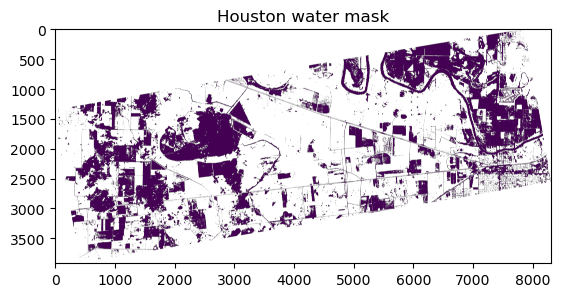

In [11]:
# In the image below, colored areas are those identified as water

plt.imshow(water_mask)
plt.title("Houston water mask")
plt.show()

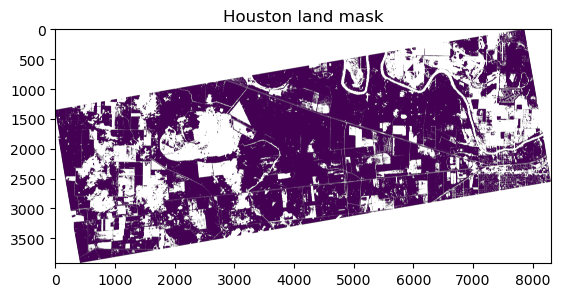

In [12]:
# In the image below, colored areas are those identified as land

plt.imshow(land_mask)
plt.title("Houston land mask")
plt.show()

You might notice that in both images, there are still small portions of water within the land areas, and vice versa. What if we wanted to clean up this mask to get a more general area of where land and water areas are? We can do this by applying morphological filters to our masks.

## Apply Filters to water mask

More info about morphological filters using OpenCV: https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

In [13]:
# kernel size for empty pixels within the mask
closing_kernel_size = 40 # kernel size for filled pixels inside of mask
opening_kernel_size = 15 # kernel size for empty pixels outside of mask

In [14]:
# Apply closing filter (remove false negatives)
closing_kernel_element = (closing_kernel_size, closing_kernel_size)
closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,closing_kernel_element)
mask_closed = cv2.morphologyEx(np.nan_to_num(water_mask), cv2.MORPH_CLOSE, closing_kernel)

# Apply opening filter (removing false positives)
opening_kernel_element = (opening_kernel_size, opening_kernel_size)
opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, opening_kernel_element)
mask_closed_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, opening_kernel)

# Ensure the clipped areas remain clipped
mask_closed_opened[mask_closed_opened == 0] = np.nan

water_mask_filtered = mask_closed_opened

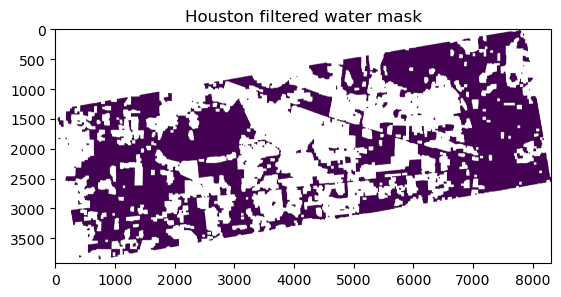

In [15]:
plt.imshow(water_mask_filtered)
plt.title("Houston filtered water mask")
plt.show()

Now we have a much better idea of the large areas affected by floods!